In [84]:
#Import Libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import shap
import optuna
from sklearn.metrics import mean_squared_error



In [85]:
#Read training data and data to test model against, both into a dataframe
data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')


In [86]:
#Remove the sale price from the training data frame and place it into a seperate data frame. Use x and y to train the model.
x = data.drop(['SalePrice'],axis=1)
y = data['SalePrice']

In [87]:
#I removed non scalar features such as 'Alley' and 'Fence'. Although they are important, I could not find a way to get them to work with xgboost
# and the model still performs good enough using just the numerical features, hence, I only used the 37 numerical features instead of all 80. I did the same for the test data as well. 

x = x.select_dtypes(include = ['float64', 'int64'])
x_test = test_data.select_dtypes(include= ['float64', 'int64'])


In [88]:
solution  = pd.read_csv('solution.csv')
y_true     = solution["SalePrice"].to_numpy()
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    model = xgb.XGBRegressor(**param)
    model.fit(x, y)
    y_pred = model.predict(x_test)
    return mean_squared_error(y_pred, y_true)


#study = optuna.create_study(direction='minimize', study_name='regression')
#study.optimize(objective, n_trials=100)

#print('Best parameters', study.best_params)

In [89]:


bestParams = {'max_depth': 9, 'learning_rate': 0.02398782236068422, 'n_estimators': 535, 'min_child_weight': 4, 'gamma': 0.14105107984219764, 'subsample': 0.6784141449085943, 'colsample_bytree': 0.4658168920071173, 'reg_alpha': 0.8978828423965367, 'reg_lambda': 0.29288514841600993, 'random_state': 392}
#I created the model using XGBoost, I gave it the best parameters that optuna decided on
#print(study.best_params)
bestFit = xgb.XGBRegressor(**bestParams)

#I trained the model using the numerical features from train.csv and the house sale prices also from train.csv. 
bestFit.fit(x,y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4658168920071173, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.14105107984219764, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02398782236068422, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             n_estimators=535, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=392, ...)

In [112]:
#I gave the now trained model the new test data which it has not seen before.
x_testOne = pd.read_csv('testOne.csv')
print(x_testOne)
#print(x_test)
x_test.to_csv('remainingCol.csv')
predictTestData = bestFit.predict(x_testOne)
predictTestData

       Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond   
0  900000          20           80    11622            5            6  \

   YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  GarageArea   
0       1950          1961           0         468  ...         730  \

   WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea   
0         140            0              0          0          120         0  \

   MiscVal  MoSold  YrSold  
0        0       6    2010  

[1 rows x 37 columns]


array([126439.58], dtype=float32)

In [91]:
#I found the real correct sale prices online on kaggle. I read those into a data frame
solution  = pd.read_csv('solution.csv')
y_true     = solution["SalePrice"].to_numpy()
#I compared the prediction that the model came up with against the correct solution to see how it fared
#I used the MSLE to check how the model performed
from sklearn.metrics import mean_absolute_error
error = (mean_absolute_error(y_true, predictTestData))
print("The score is ", error )


The score is  14539.725628105723


In [92]:
#I found the real correct sale prices online on kaggle. I read those into a data frame
solution  = pd.read_csv('solution.csv')
y_true     = solution["SalePrice"]

#I compared the prediction that the model came up with against the correct solution to see how it fared
#I used the MSLE to check how the model performed
from sklearn.metrics import mean_squared_error
error = mean_squared_error(y_true,predictTestData)
#error = np.sqrt( mean_squared_log_error(y_true, predictTestData) )
print("The score is " % error )
print(predictTestData)

The score is 
[127487.27 163728.19 182647.12 ... 183730.38 113497.46 234878.19]


In [93]:
shap.initjs()

In [94]:
#I took a random sample of the input houses because getting shap values for all of them would be very resource intensive
#since the xgb uses a gb tree, I used the shap tree explainer and gave it the xgb model as a parameter
X_sampled = x.sample(100, random_state=10)
explainer = shap.TreeExplainer(bestFit)
shap_values = explainer.shap_values(X_sampled)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [95]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_sampled.iloc[0,:])
#this plot shows the impact of each invidividual feature
#The next two plots also show the metrics of each feature

In [96]:
shap.force_plot(explainer.expected_value, shap_values, x)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


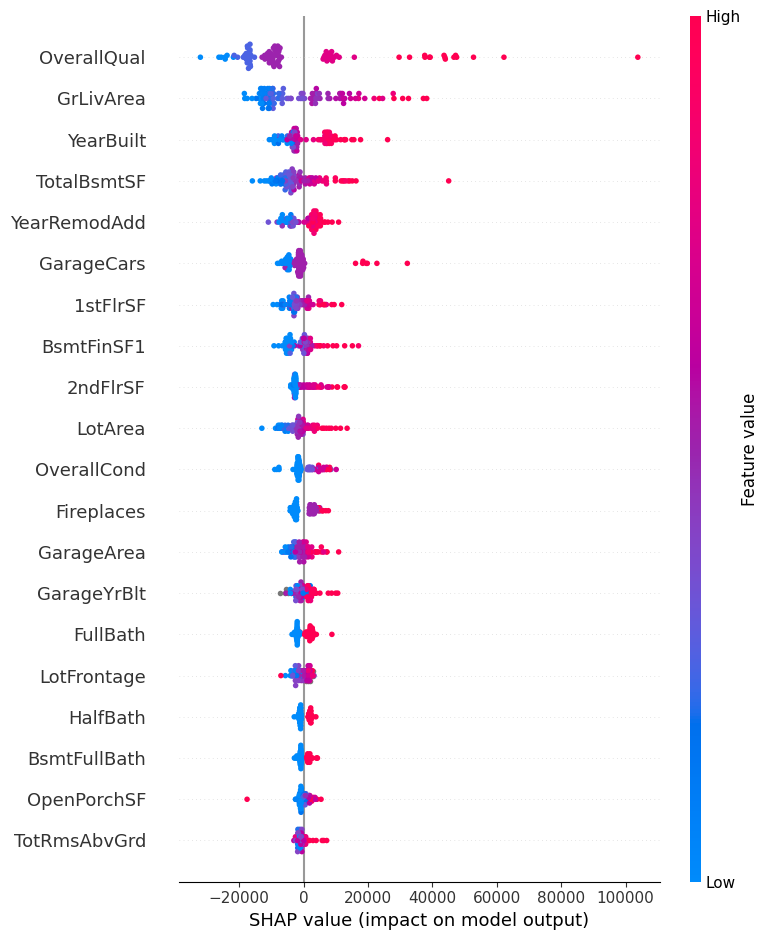

In [97]:
shap.summary_plot(shap_values, X_sampled)

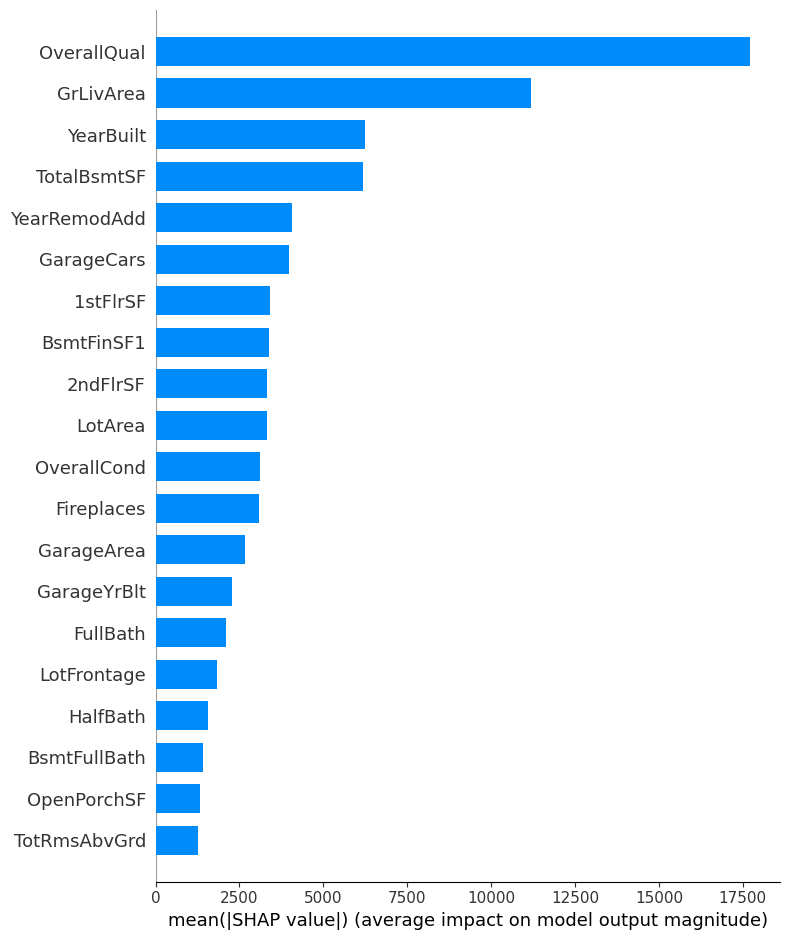

In [98]:
shap.summary_plot(shap_values, x, plot_type="bar")

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


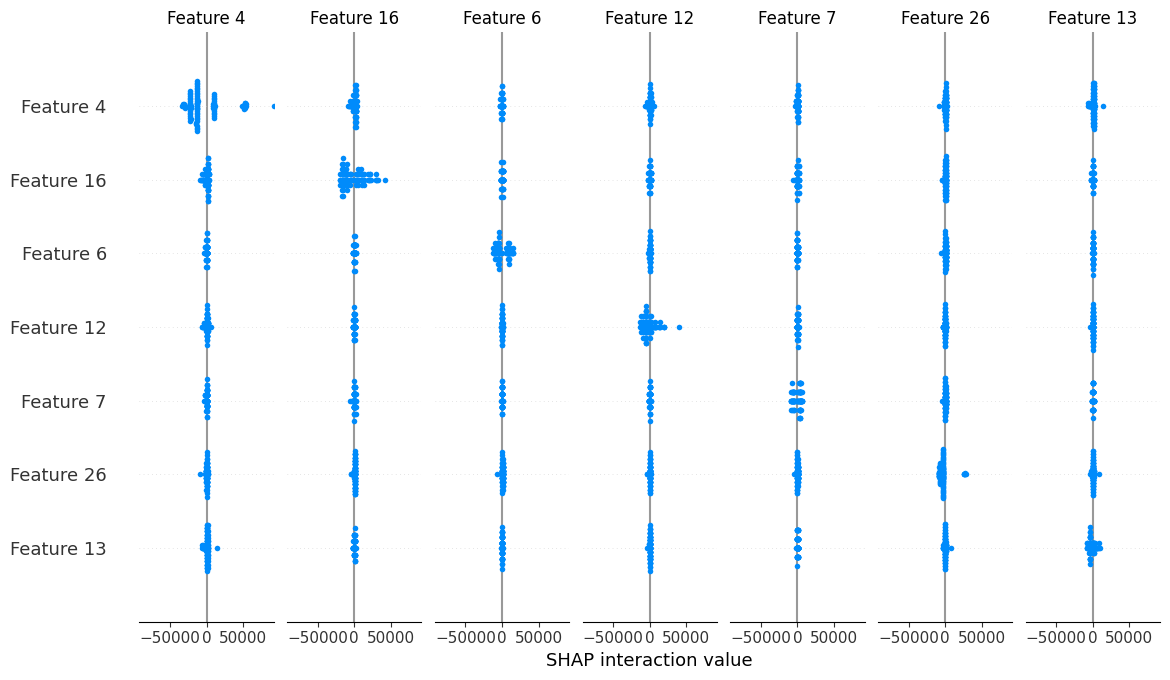

In [99]:
shap_interaction_values = explainer.shap_interaction_values(X_sampled)
shap.summary_plot(shap_interaction_values)

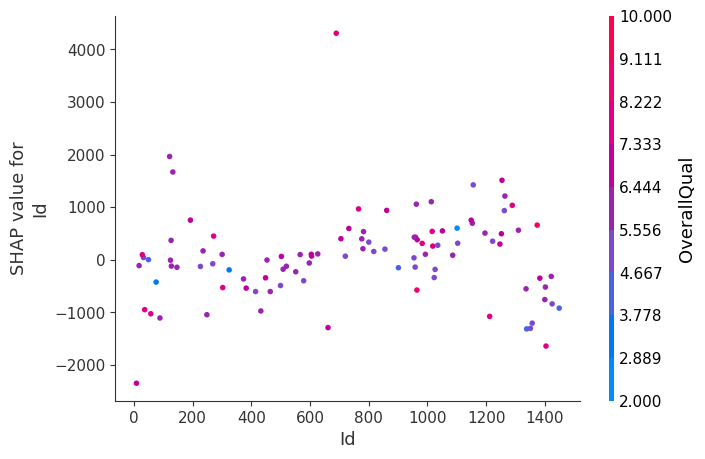

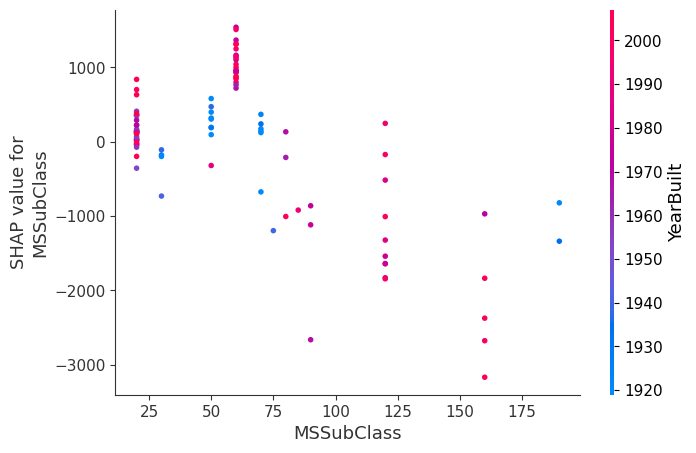

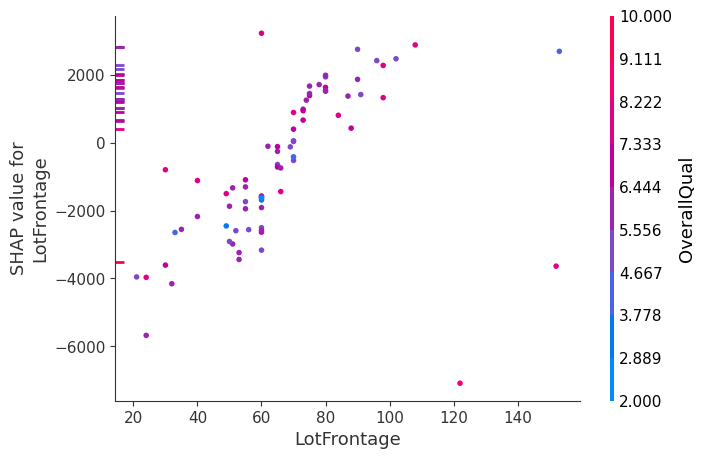

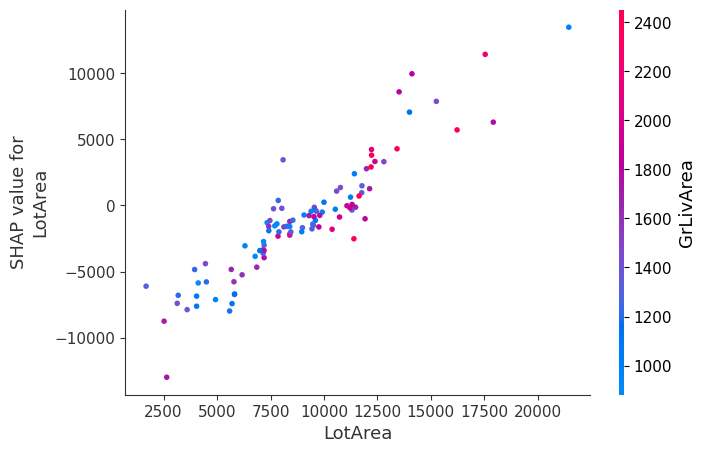

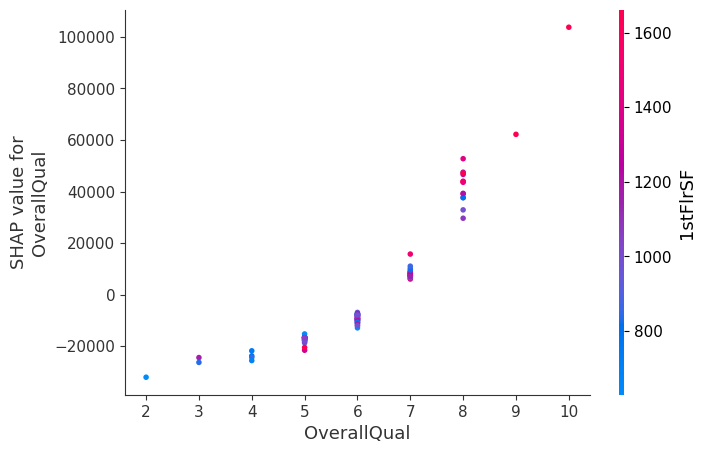

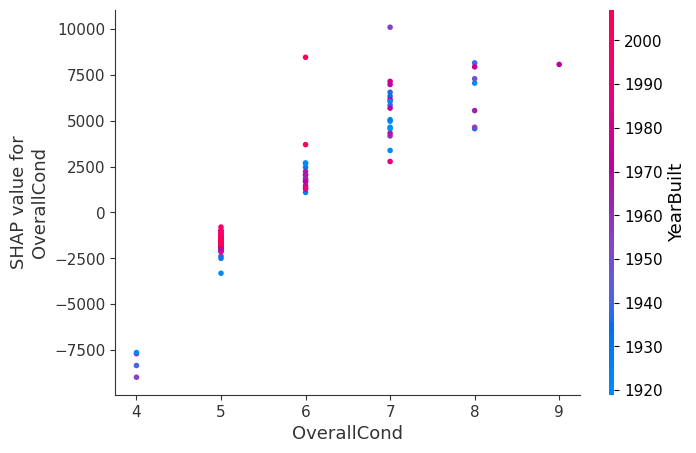

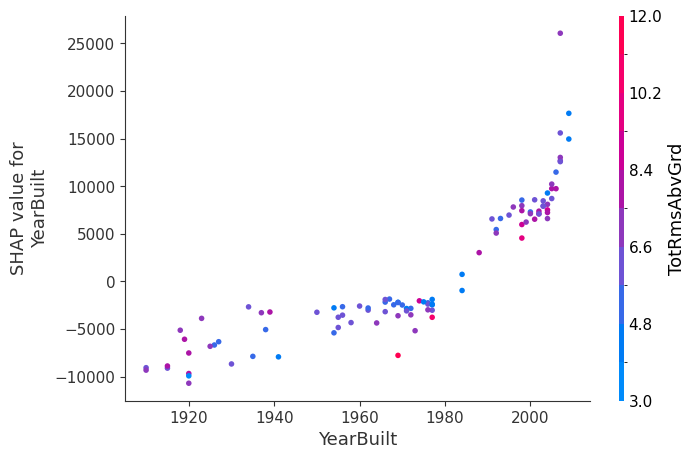

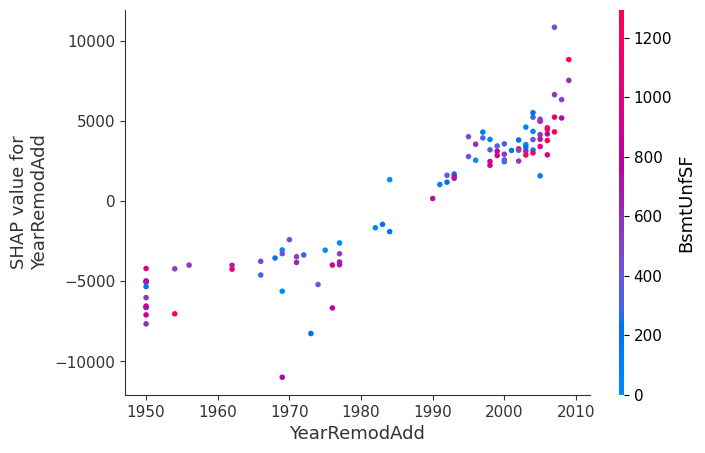

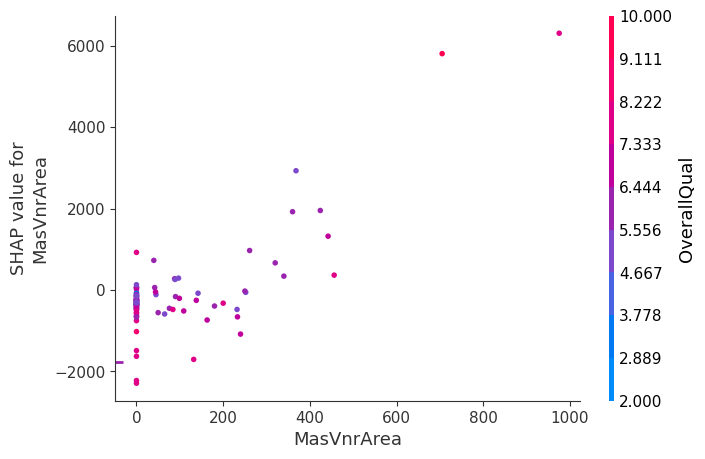

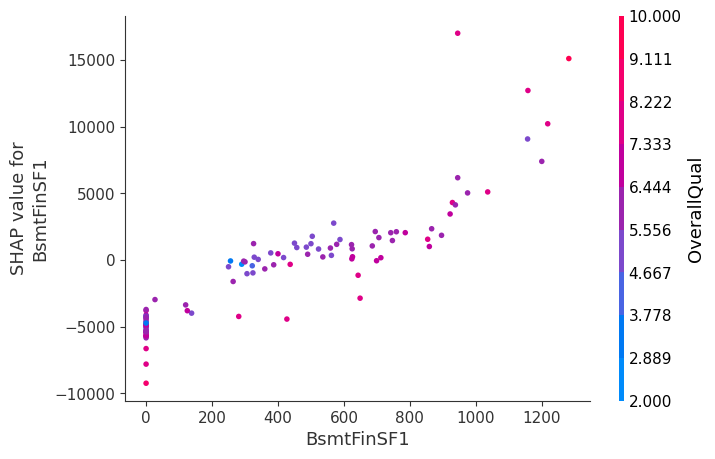

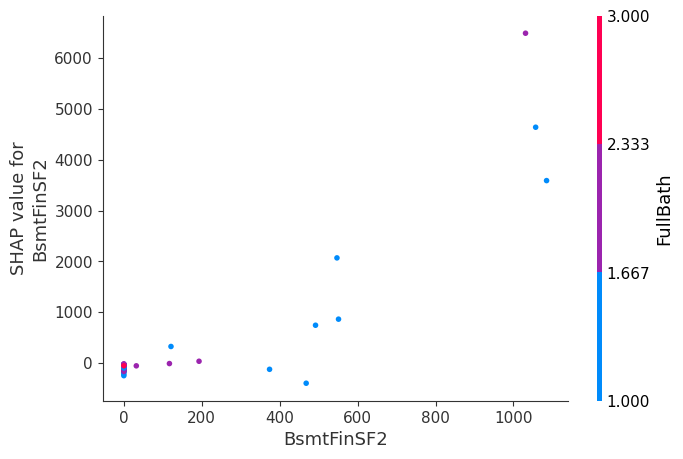

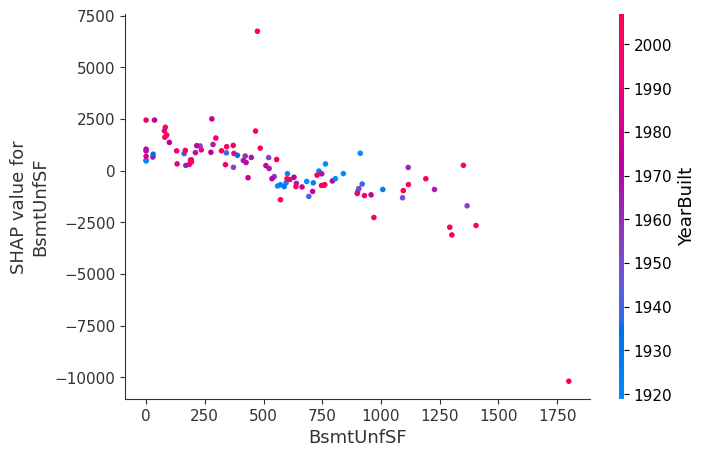

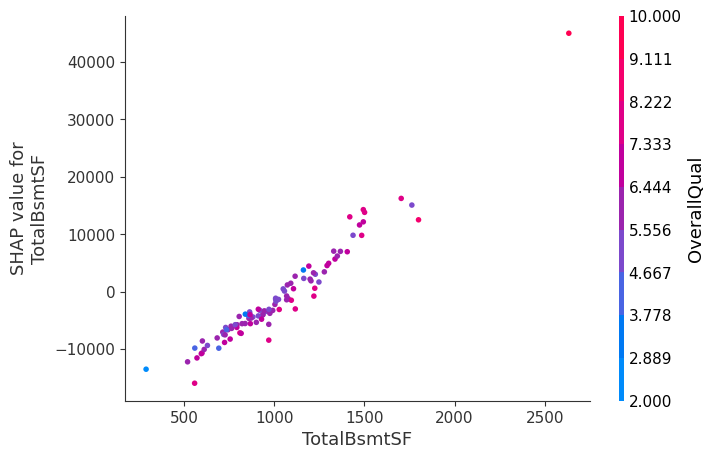

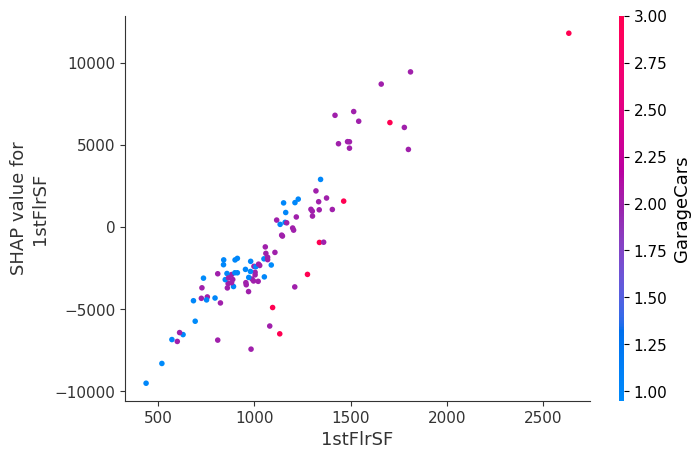

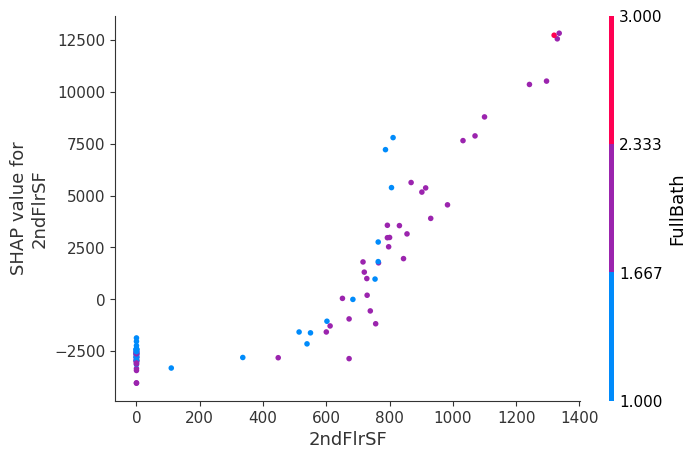

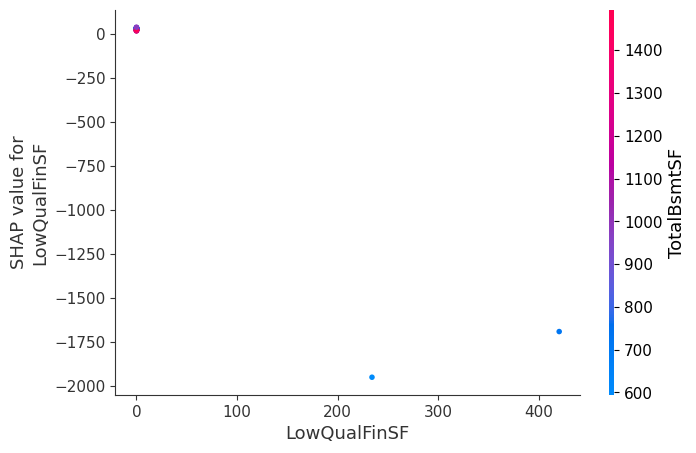

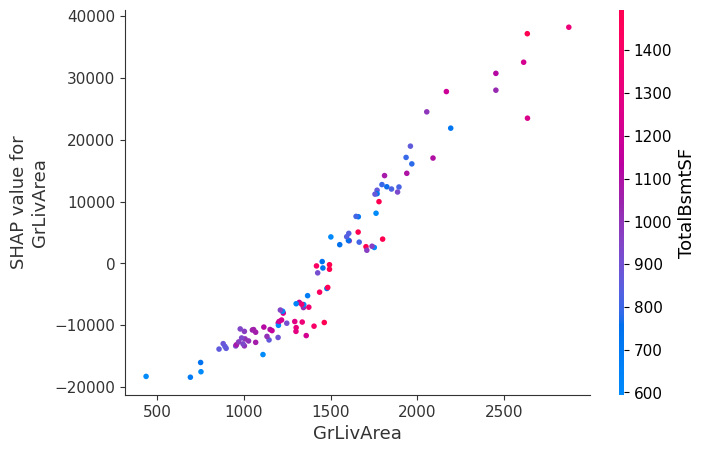

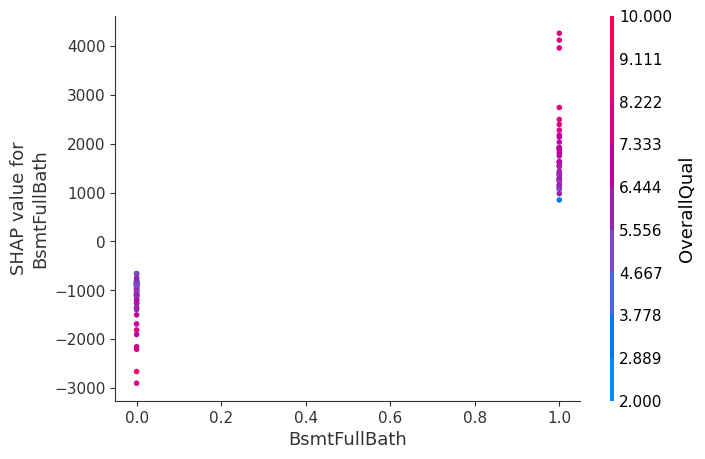

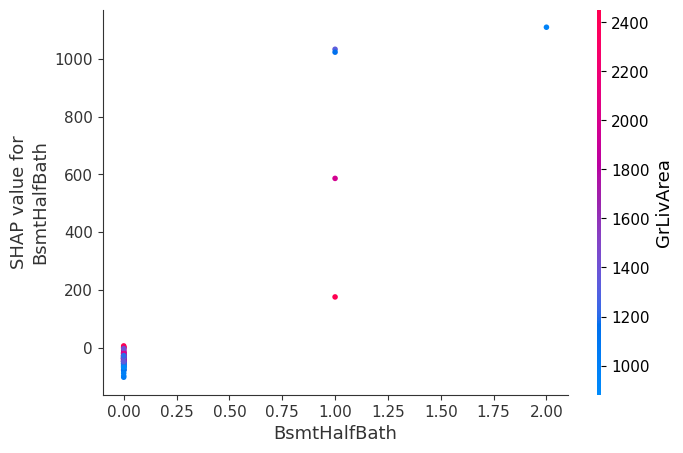

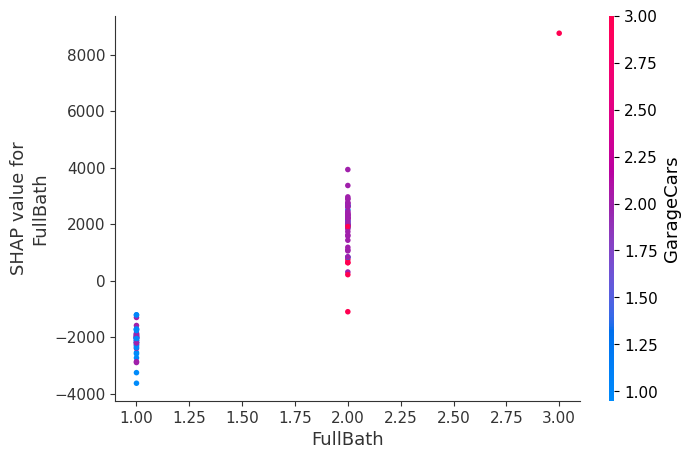

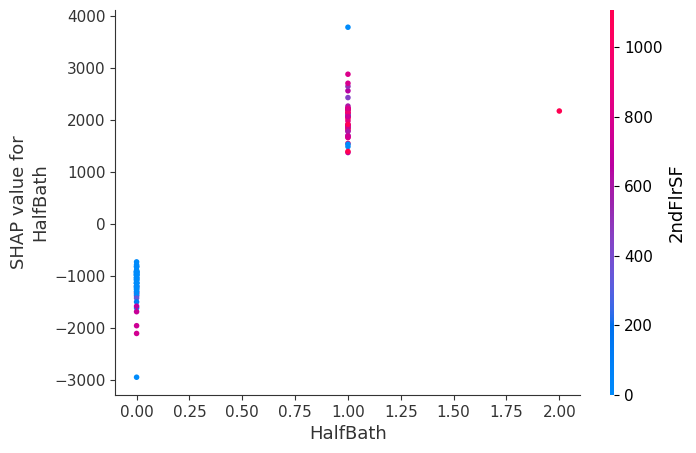

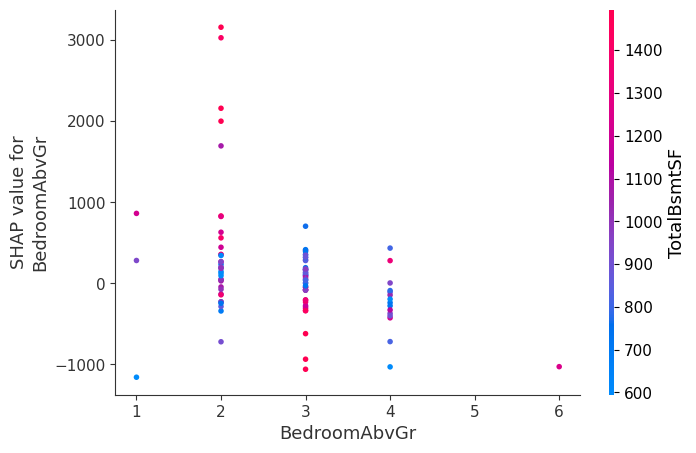

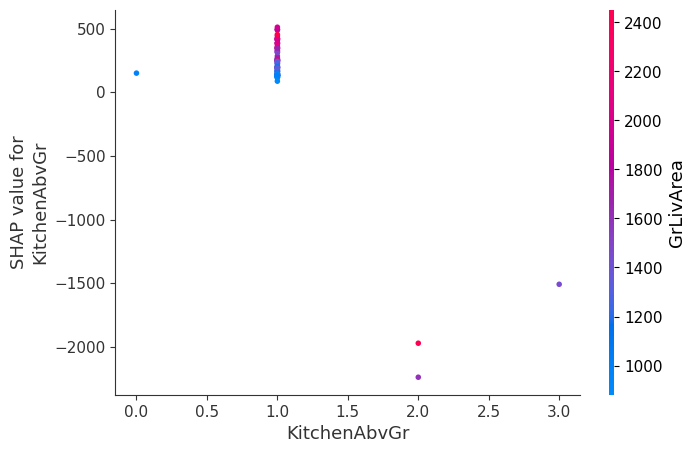

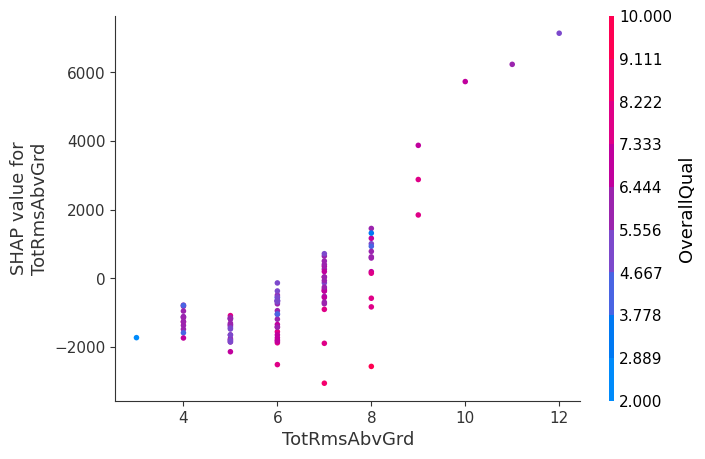

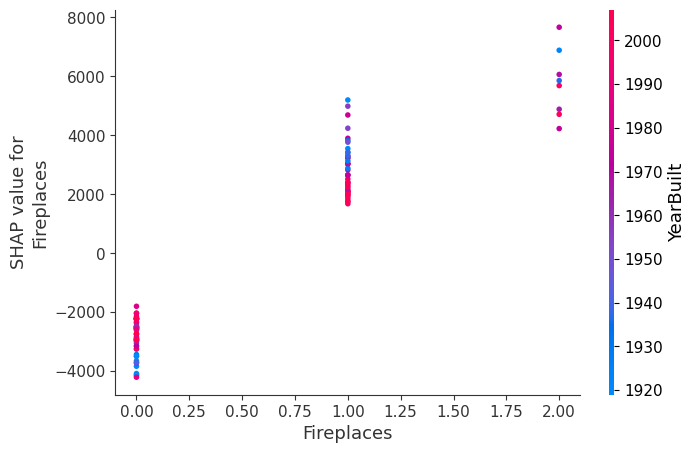

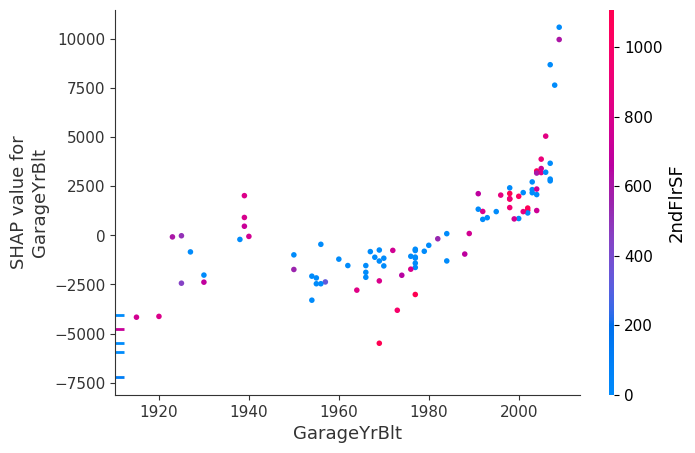

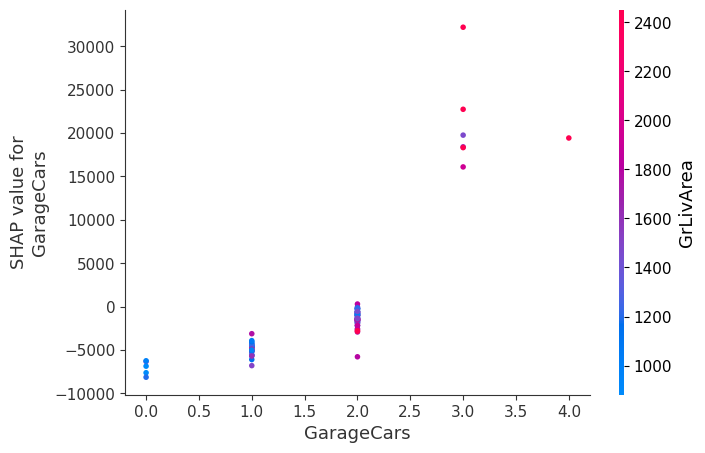

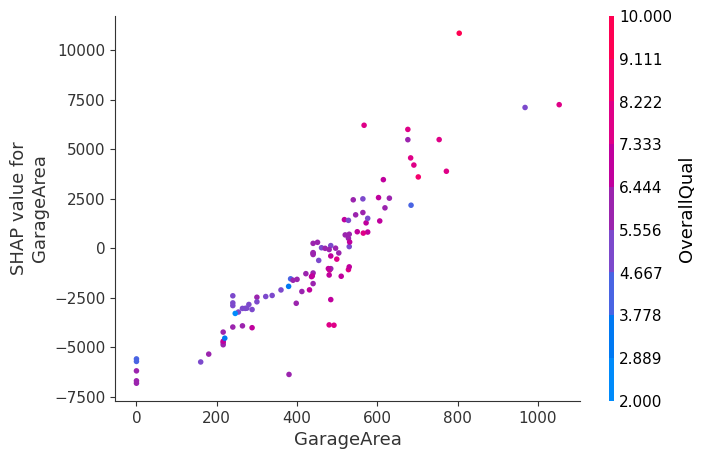

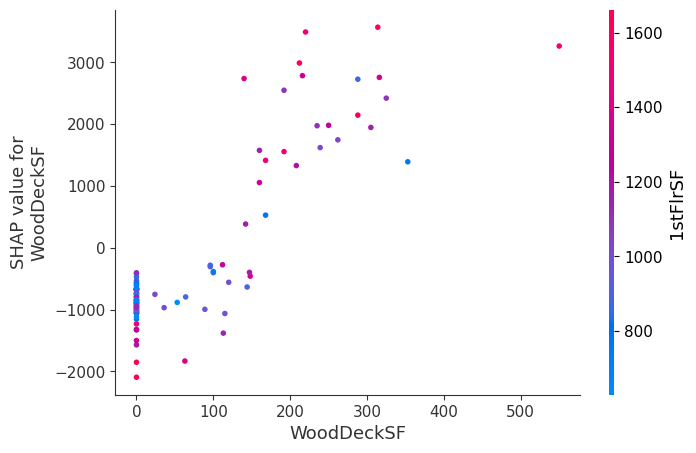

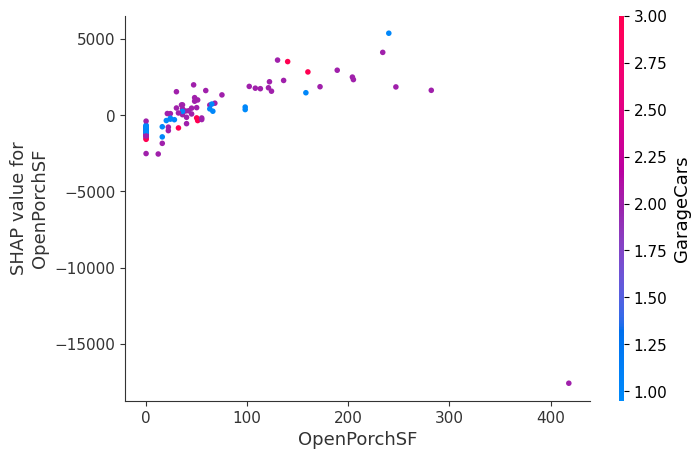

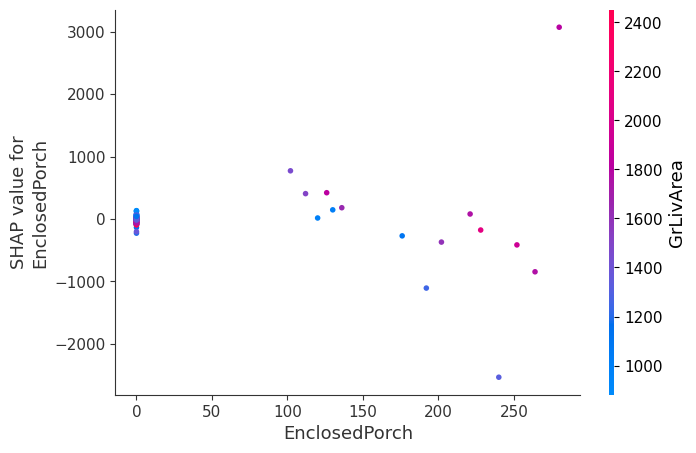

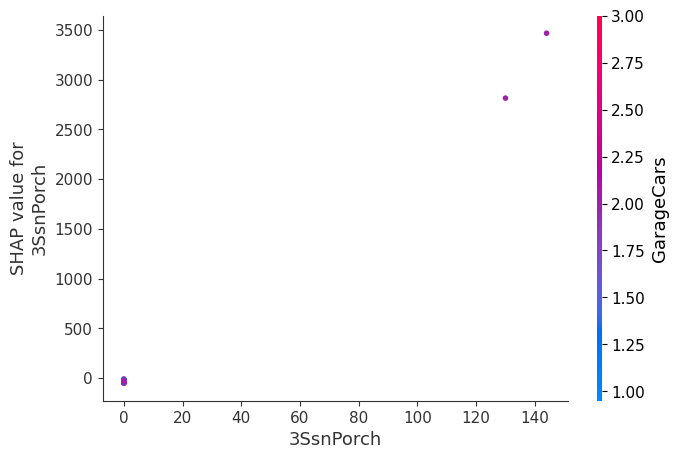

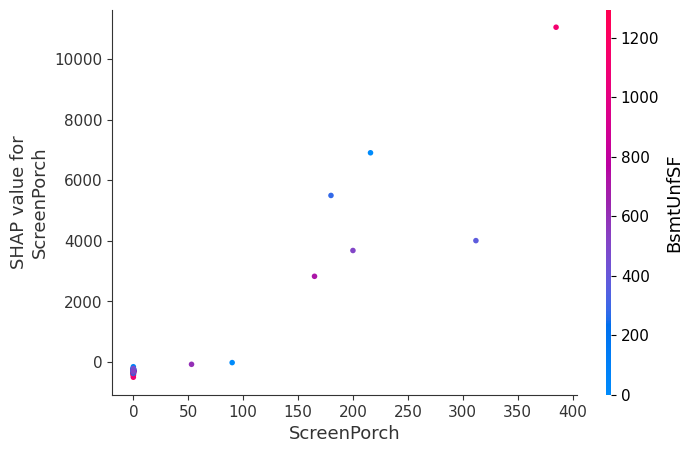

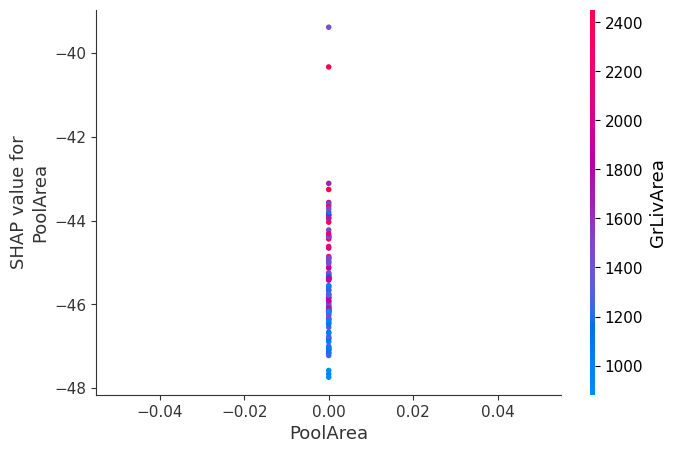

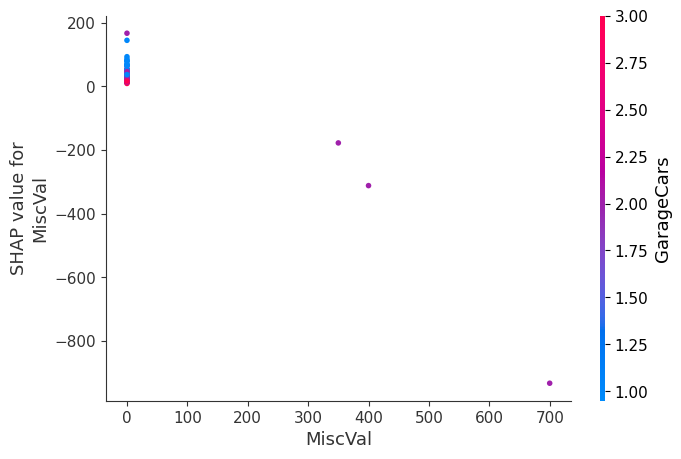

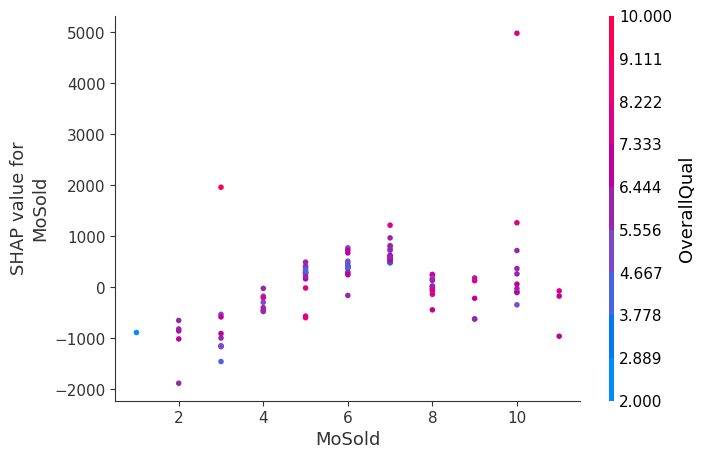

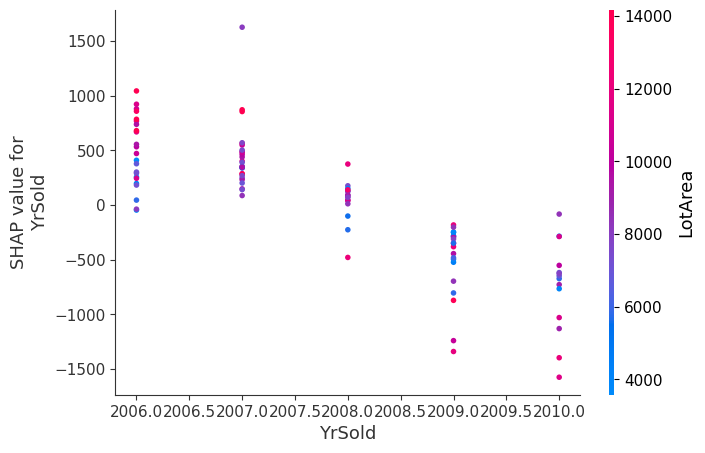

In [100]:
#This loop plots through all of the numerical features and shows the interaction values of each feature. 
for i in range(37):
    shap.dependence_plot(i, shap_values, X_sampled)